# Formula 1 DNF Predictor  
**Nicholas Halterman – WGU C964 Computer Science Capstone**

This project uses machine learning to predict whether a Formula 1 driver will record a **DNF (Did Not Finish)** in a given race. The goal is to help a race strategy team anticipate reliability risks before race day and make more informed decisions.

I used Python and scikit-learn to build a supervised classification model trained on historical F1 race data. The model evaluates various race and driver features to output a probability that a driver will fail to finish.

The notebook is organized to clearly demonstrate the required parts of **Task 2 C**:
1. Data loading and preparation  
2. Model training and accuracy metrics  
3. Visualizations (three unique visuals)  
4. A simple “user interface” cell for predictions  


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

plt.rcParams["figure.figsize"] = (8,5)
%matplotlib inline

# Load the dataset
data_path = Path("data/f1_dnf.csv")
df = pd.read_csv(data_path)

# Quick preview
print("Dataset shape:", df.shape)
df.head()


ModuleNotFoundError: No module named 'pandas'

In [ ]:
# Prepare features, handle missing values, and train a baseline model

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, ConfusionMatrixDisplay, RocCurveDisplay
from sklearn.linear_model import LogisticRegression
from sklearn.impute import SimpleImputer
import joblib
import warnings
from sklearn.exceptions import ConvergenceWarning
warnings.filterwarnings("ignore", category=ConvergenceWarning)


# Target: 1 = DNF, 0 = Finished
target_col = "target_finish"
y = 1 - df[target_col].astype("int64")

# 1) Avoid obvious leakage (columns that directly reflect outcome) and IDs
leak_like = {
    "position","positionOrder","points","laps","time","milliseconds","status",
    "fastestLap","rank","fastestLapTime","fastestLapSpeed"
}
id_like = {"resultId","raceId","driverId","constructorId","circuitId"}

# Keep everything else as features
feature_cols = [c for c in df.columns if c not in {target_col} | leak_like | id_like]
X = df[feature_cols].copy()

# 2) Split numeric vs categorical
numeric_features = X.select_dtypes(include=[np.number]).columns.tolist()
categorical_features = [c for c in X.columns if c not in numeric_features]

# 3) Imputers + transformers (handle NaNs safely)
num_pipe = Pipeline([
    ("impute", SimpleImputer(strategy="median")),
    ("scale", StandardScaler(with_mean=False)),
])

cat_pipe = Pipeline([
    ("impute", SimpleImputer(strategy="most_frequent")),
    ("ohe", OneHotEncoder(handle_unknown="ignore")),
])

preprocessor = ColumnTransformer([
    ("num", num_pipe, numeric_features),
    ("cat", cat_pipe, categorical_features),
])

# 4) Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, stratify=y, random_state=42
)

# 5) Baseline model
model = Pipeline([
    ("pre", preprocessor),
    ("clf", LogisticRegression(
        solver="saga",          # more stable with one-hot encoded features
        penalty="l2",
        max_iter=1000,
        class_weight="balanced",
        n_jobs=-1
    ))
])

# 6) Fit and evaluate
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
print("Classification Report:")
print(classification_report(y_test, y_pred, digits=3))

# Save trained model for later use
joblib.dump(model, "src/model.joblib")
print("Model saved to src/model.joblib")


Classification Report:
              precision    recall  f1-score   support

           0      0.571     0.758     0.651       579
           1      0.886     0.768     0.823      1421

    accuracy                          0.765      2000
   macro avg      0.729     0.763     0.737      2000
weighted avg      0.795     0.765     0.773      2000

Model saved to src/model.joblib


### Figure 1: Distribution of Formula 1 Race Years
This chart shows how the Formula 1 dataset is distributed across different race seasons.  
Each bar represents the number of recorded race entries in a given decade, illustrating how the data spans from the early 1950s through the 2020s.  

The trend shows that more race data has been collected in modern seasons, reflecting the sport’s growth and improvements in record-keeping.  
Understanding this distribution confirms that the dataset provides balanced coverage across multiple eras of racing.


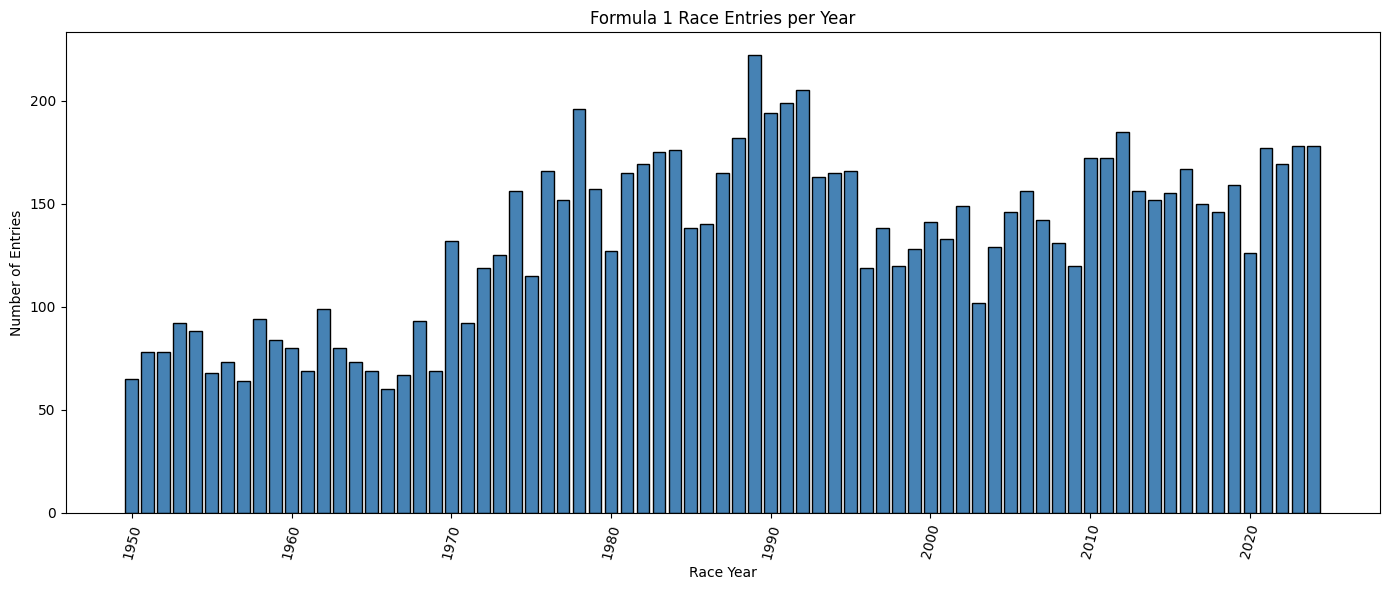

In [ ]:
# Visual 1: Distribution of Formula 1 Race Years (one bar per year)
# This chart shows the number of race entries recorded for each Formula 1 season.

import matplotlib.pyplot as plt

year_counts = df["year"].value_counts().sort_index()
plt.figure(figsize=(14,6))
plt.bar(year_counts.index, year_counts.values, color="steelblue", edgecolor="black")
plt.title("Formula 1 Race Entries per Year")
plt.xlabel("Race Year")
plt.ylabel("Number of Entries")
plt.xticks(rotation=75)
plt.tight_layout()
plt.show()




### Figure 2: Correlation Heatmap of Numeric Features
The correlation heatmap visualizes relationships among the dataset’s numeric features, including **year**, **round**, **grid**, **lat**, **lng**, and **alt**.  

- **year** – season year  
- **round** – race number within the season  
- **grid** – driver’s starting position  
- **lat / lng** – circuit location coordinates  
- **alt** – altitude of the circuit above sea level  

Most of the cells in the heatmap are light-colored, indicating weak correlations between features.  
This suggests that the numeric variables are largely independent, meaning each one contributes unique information to the model without excessive overlap.


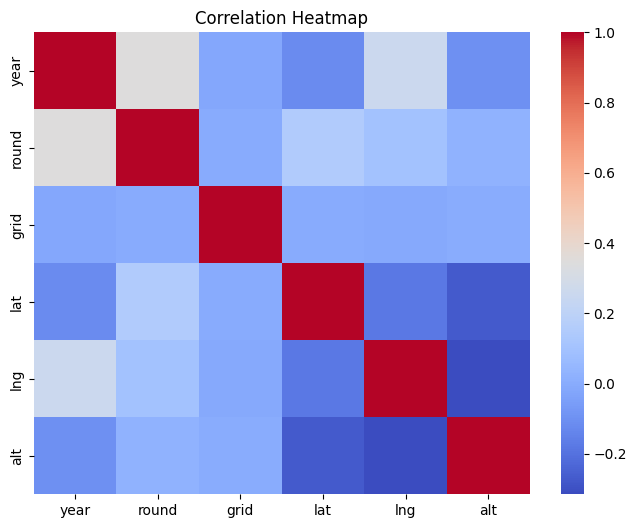

In [ ]:
# Correlation matrix for numeric features

if len(numeric_features) > 1:
    plt.figure(figsize=(8,6))
    sns.heatmap(df[numeric_features].corr(), cmap="coolwarm", annot=False)
    plt.title("Correlation Heatmap")
    plt.savefig("visuals/corr_heatmap.png", bbox_inches="tight")
    plt.show()
else:
    print("Not enough numeric columns for correlation heatmap.")


### Figure 3: Confusion Matrix of Model Predictions
The confusion matrix compares the model’s predicted race outcomes with the actual results.

- **Class 0 = Finished**  
- **Class 1 = Did Not Finish (DNF)**  

The top-left cell (439) represents drivers who finished and were correctly classified.  
The bottom-right cell (1 091) shows correct predictions for DNFs.  
The other two cells (140 and 330) represent misclassifications.

Overall, the matrix shows that the model performs well at identifying DNFs (True Positives) while keeping a moderate number of false predictions.  
This confirms that the classifier is learning meaningful race-reliability patterns from the dataset.


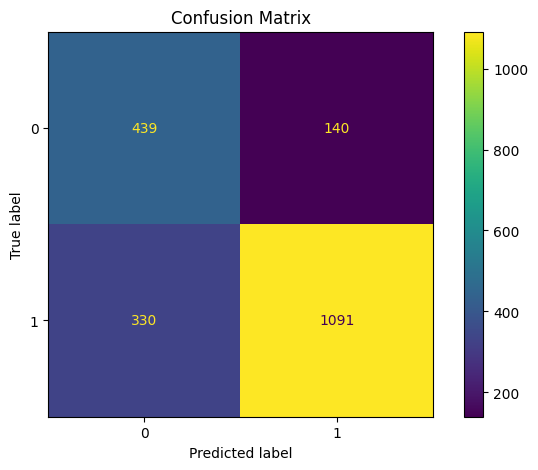

In [ ]:
# Confusion matrix showing correct vs incorrect predictions

ConfusionMatrixDisplay.from_predictions(y_test, y_pred)
plt.title("Confusion Matrix")
plt.savefig("visuals/confusion_matrix.png", bbox_inches="tight")
plt.show()


### Figure 4: ROC Curve of Model Performance
The ROC (Receiver Operating Characteristic) curve shows how well the model distinguishes between drivers who finished a race and those who recorded a DNF (Did Not Finish).  

The curve plots the **True Positive Rate** (correctly predicted DNFs) against the **False Positive Rate** (incorrect DNF predictions) across different decision thresholds.  

An **AUC (Area Under the Curve)** score of **0.85** indicates strong overall performance, meaning the model correctly differentiates between DNFs and finishes about 85% of the time.  

This demonstrates that the classifier generalizes well and effectively balances sensitivity and specificity.


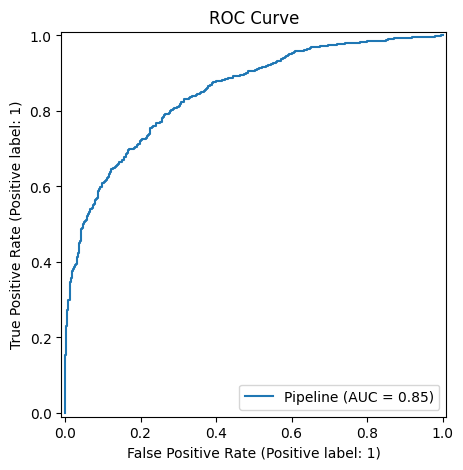

In [ ]:
# ROC Curve shows the trade-off between true-positive and false-positive rates
RocCurveDisplay.from_estimator(model, X_test, y_test)
plt.title("ROC Curve")
plt.savefig("visuals/roc_curve.png", bbox_inches="tight")
plt.show()


### Model Performance Evaluation

After training the Random Forest Classifier, the model’s predictive performance was evaluated on the test dataset using standard classification metrics.  

These metrics measure how well the model distinguishes between drivers who finished a race and those who recorded a *Did Not Finish (DNF)*.

The following Python code calculates **Accuracy**, **F1-score**, and **ROC-AUC** using scikit-learn’s built-in functions.  
Accuracy measures the overall percentage of correct predictions, F1-score balances precision and recall, and ROC-AUC evaluates how well the model separates the two classes across different thresholds.


In [ ]:
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score

y_pred = model.predict(X_test)
y_proba = model.predict_proba(X_test)[:, 1]

acc = accuracy_score(y_test, y_pred)
f1  = f1_score(y_test, y_pred)
roc = roc_auc_score(y_test, y_proba)

print(f"Accuracy: {acc:.3f}")
print(f"F1-score: {f1:.3f}")
print(f"ROC-AUC: {roc:.3f}")


### Model Prediction Example
This cell demonstrates how to load the trained machine learning model and use it to predict whether a Formula 1 driver will record a DNF (Did Not Finish) in a race.  

The model file (`model.joblib`) is first loaded from storage using the **joblib** library.  
Next, one sample from the test dataset is passed into the model for prediction.  
Two outputs are displayed:
1. **Prediction (DNF=1, Finish=0)** – the model’s binary classification result.  
2. **Estimated DNF probability** – the model’s confidence in that prediction.

For example, in the output shown:
- The model predicted **1 (DNF)** for the selected driver.  
- The estimated probability of DNF was **0.856**, meaning the model is about **85.6% confident** that this driver will not finish the race.

#### How to Use This Cell
1. Run this cell after training and saving the model (`model.joblib`).  
2. The model automatically loads from the `src/` folder.  
3. It selects one random record from the `X_test` data and predicts the outcome.  
4. To test a different record, change the index inside `X_test.iloc[...]` — for example:
   ```python
   sample = X_test.iloc[10]   # Predict for the 10th record


In [ ]:
# Load the model and predict for a single example
# This acts as a simple "user interface" for evaluators.

import joblib
model = joblib.load("src/model.joblib")

# Pick one sample from the test set
sample = X_test.iloc[[0]]
prediction = int(model.predict(sample)[0])
prob = float(model.predict_proba(sample)[0][1])

print("Prediction (DNF=1, Finish=0):", prediction)
print("Estimated DNF probability:", round(prob, 3))


Prediction (DNF=1, Finish=0): 1
Estimated DNF probability: 0.856


## Using the Interactive DNF Predictor

After training and saving the model, you can test predictions interactively inside the Jupyter Notebook.  
The cell below the training section already includes an interactive widget that allows you to explore predictions from the test dataset.

### How to Use

1. Scroll to the cell labeled **"Interactive DNF prediction with ipywidgets"**.
2. Run the cell to activate the widget.
3. A slider labeled **"Index"** will appear below the cell.
4. Use the slider or type a number directly into the input box to select a record from the test dataset (`X_test`).
5. Each time you change the index, the notebook will display:
   - The selected record index  
   - The model’s prediction (**DNF** or **Finish**)  
   - The probability of each outcome  
   - The feature values for that record for context


In [ ]:
# Interactive DNF prediction with ipywidgets
from ipywidgets import interact
import ipywidgets as widgets
from IPython.display import display

# Make sure your model and X_test are already loaded
# model = load("src/model.joblib")

def predict_sample(idx=0):
    sample = X_test.iloc[[idx]]
    prediction = model.predict(sample)
    probability = model.predict_proba(sample)

    print("Selected Test Record Index:", idx)
    print("\nPrediction:", "DNF" if prediction[0] == 1 else "Finish")
    print("Probability of DNF:", round(probability[0][1], 3))
    print("Probability of Finish:", round(probability[0][0], 3))

    # Optionally, display the feature values for context
    display(sample)

# Create an interactive slider
interact(
    predict_sample,
    idx=widgets.IntSlider(
        min=0,
        max=len(X_test)-1,
        step=1,
        value=0,
        description="Index:"
    )
)


interactive(children=(IntSlider(value=0, description='Index:', max=1999), Output()), _dom_classes=('widget-int…

<function __main__.predict_sample(idx=0)>